Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: FILL IN YOUR NAMES HERE

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

## Context
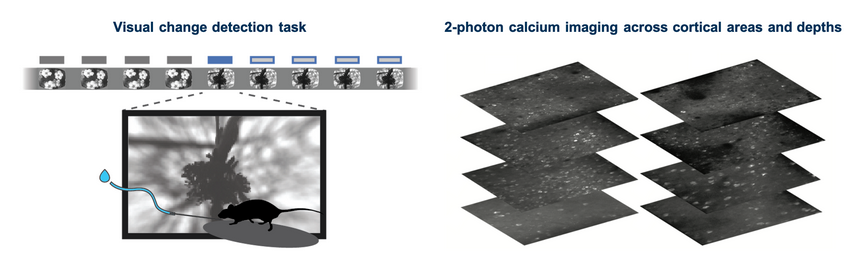

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

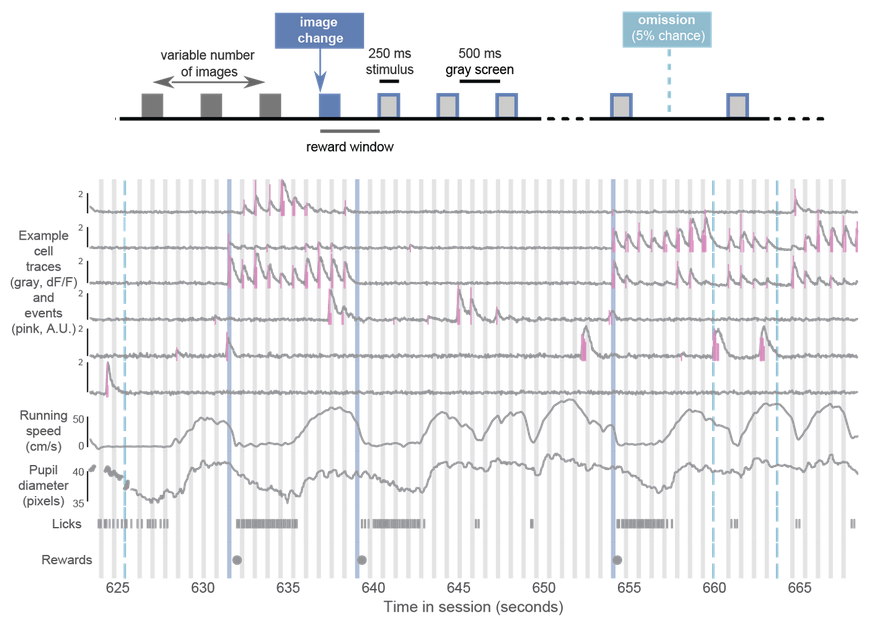

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the stimulus frames
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a locally sparse noise stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

### Question session #1
- Dataset paper link? 

https://portal.brain-map.org/explore/circuits/visual-behavior-2p
- Maximum activity projection? 

*Just plot it*
- ROI?
- Features in stimulus metadata?
- What do licks mean? What does mouse get reward for? PAPER PAPER PAPER PAPER



### Question session #2
- What is spatial structure? Is it in the brain? Or in spatial location of a visual stimulus?
- Cell types mentioned - no data on them

## Imports

In [1]:
# import packages here

import numpy as np
import pandas as pd
from scipy import signal, stats

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
data_path = Path("../data/")

In [2]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path / "dff_data_rf.npz", allow_pickle=True)
    data = dict(data)
    array2df(data, "stim_table", ["frame", "start", "end"])
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")

from pathlib import Path
data_path = Path("../data/")

data = load_data(data_path)

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



In [3]:
times = data['t'].copy()
dff = data['dff'].copy()
stim_table = data['stim_table'].copy()
stim = data['stim'].copy()
roi = data['roi_masks'].copy()
max_projection = data['max_projection'].copy()

n_neurons, n_times = dff.shape
stim_shape = stim[0].shape
n_stim = stim_table.shape[0]
roi_shape = max_projection.shape

print(f"Max time: {times[-1]}")
print(f"Number of neurons: ", n_neurons)
print("Stimulus frame shape: ", stim_shape)
print("Number of presented stimuli: ", n_stim)

Max time: 3524.5851
Number of neurons:  189
Stimulus frame shape:  (16, 28)
Number of presented stimuli:  8880


## Question

**Is there spatial structure on the location of the receptive fields?** 

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.

**Sub-tasks**

1. Pre-processing
    - Load the data and inspect its dimensions, types, and values.
    - Filter out any missing, invalid, or corrupted data points.
    - Normalize the data to remove any unwanted effects of scale, noise, or outliers.
    - Select the subset of data that corresponds to the locally sparse noise stimulus.
    - Visualize the data using plots or maps to explore its distribution and variation.
2. Spike inference
    - Choose a suitable spike inference method for your data, such as deconvolution, template matching, or probabilistic modeling¹²³.
    - Apply the spike inference method to the calcium imaging data to estimate the spike trains of individual neurons.
    - Evaluate the accuracy and reliability of the spike inference method using metrics such as correlation coefficient, false discovery rate, or receiver operating characteristic curve¹²³.
    - Compare the spike inference results across different neurons, stimuli, and trials.
3. Tuning function fitting
    - Define a tuning function model that describes how the spike rate of a neuron depends on the stimulus features, such as orientation, spatial frequency, or contrast⁴⁵⁶.
    - Fit the tuning function model to the spike data using a suitable optimization or estimation method, such as least squares, maximum likelihood, or Bayesian inference⁴⁵⁶.
    - Assess the goodness-of-fit of the tuning function model using metrics such as coefficient of determination, Akaike information criterion, or Bayesian information criterion⁴⁵⁶.
    - Estimate the tuning parameters of each neuron, such as preferred orientation, bandwidth, or amplitude⁴⁵⁶.
4. Statistical testing
    - Formulate a null hypothesis and an alternative hypothesis about the spatial structure of the receptive fields⁷⁸⁹.
    - Choose a suitable statistical test for your data and hypotheses, such as spatial autocorrelation test, global envelope test, or Mantel test⁷⁸⁹.
    - Perform the statistical test on your data and obtain a test statistic and a p-value⁷⁸⁹.
    - Interpret the results of the statistical test and draw conclusions about the spatial structure of the receptive fields⁷⁸⁹.

Optional tasks: 

5. Proper statistical assessment
    - Check the assumptions and limitations of your chosen statistical test and verify that they are met by your data⁷⁸⁹.
    - Perform sensitivity analysis or robustness checks to evaluate how your results depend on your choices of parameters, methods, or models⁷⁸⁹.
    - Report your results with confidence intervals or error bars to indicate the uncertainty and variability of your estimates⁷⁸⁹.
    - Discuss the implications and significance of your results for your main question and relate them to previous studies or theories⁷⁸⁹.

6. Focus on specific cell types
    - Identify the different cell types in your data based on their genetic markers, morphology, or electrophysiology  .
    - Select a subset of neurons that belong to a specific cell type of interest, such as excitatory, inhibitory, or modulatory  .
    - Repeat the previous tasks (1-5) for the selected subset of neurons and compare the results with the whole population  .
    - Investigate how the cell type affects the spatial structure of the receptive fields and the tuning properties of the neurons  .


Source:
(1) Inferring spikes from calcium imaging in dopamine neurons. https://www.biorxiv.org/content/10.1101/2020.12.05.412965v1. 
(2) Inferring Neuronal Dynamics from Calcium Imaging Data Using ... - PLOS. https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004736.
(3) Inferring spikes from calcium imaging in dopamine neurons. https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0252345.
(4) Inferring spikes from calcium imaging in dopamine neurons. https://collaborate.princeton.edu/en/publications/inferring-spikes-from-calcium-imaging-in-dopamine-neurons.
(5) Receptive Field Shift and Shrinkage in Macaque Middle Temporal Area .... https://www.jneurosci.org/content/28/36/8934.
(6) The Development of Receptive Field Tuning Properties in Mouse Binocular .... https://www.jneurosci.org/content/42/17/3546.
(7) Neurobiology 5.2: Tuning Curves, Receptive Fields, Sensory threshold. https://www.youtube.com/watch?v=YvxdNF8oGiQ.
(8) GeoDa: An Introduction to Spatial Data Analysis | Spatial .... https://spatial.uchicago.edu/geoda.
(9) Global Envelope Tests for Spatial Processes - Oxford Academic. https://academic.oup.com/jrsssb/article/79/2/381/7041937.

**This one should be deleted before submission** <br>
**Sources from where we can use the code for this data analysis**

- [1](^1^): Python package for analyzing behavioral data for Brain Observatory: Visual Behavior 2P Project. It contains code for creating a core data structure with licks, rewards, trials, running, visual stimuli, and metadata. It also has functions for plotting, filtering, and transforming the data. It is an official repository from the Allen Institute and it is actively maintained and updated.
- [2](^2^): Tensorflow implementation of DETR: Object Detection with Transformers. It includes code for inference, training, and finetuning the model on various datasets, including the Visual Behavior 2P data. It is an unofficial repository from a group of researchers and it is not affiliated with the Allen Institute or the original authors of DETR.
- [3](^3^): Documentation page for the Allen SDK, which is a Python library that provides tools for accessing and analyzing data from the Allen Brain Atlas projects. It has a section on how to get started with the Visual Behavior 2P data, including how to download, load, and explore the data using the SDK methods and classes.
- [4](^4^): Web page that showcases the Python package from [1](^1^) as an awesome Python project. It provides a brief overview of the package and its features, as well as a link to the GitHub repository.


Source: 
(1) GitHub - AllenInstitute/visual_behavior_analysis: Python package for .... https://github.com/AllenInstitute/visual_behavior_analysis.<br>
(2) GitHub - Visual-Behavior/detr-tensorflow: Tensorflow implementation of .... https://github.com/Visual-Behavior/detr-tensorflow.<br>
(3) GETTING STARTED — Allen SDK dev documentation - Read the Docs. https://allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html.<br>
(4) Python package for analyzing behavioral data for Brain Observatory .... https://pythonawesome.com/python-package-for-analyzing-behavioral-data-for-brain-observatory-visual-behavior/.


## Data exploration

### Stimuli

#### Dataframes with descriptions

In [4]:
data.keys()

dict_keys(['t', 'dff', 'stim_table', 'stim', 'roi_masks', 'max_projection', 'running_speed', 'stim_epoch_table'])

In [5]:
data['t']

array([   9.33015,    9.36332,    9.39649, ..., 3524.51876, 3524.55193,
       3524.5851 ])

**Summary of each Key in data**

n_times = 105968 #no. of frames <br>
n_neurons = 189 #no. of neurons <br>
n_stim = 8880 #no. of stiumuls <br>
height, width = 16, 25   #Stimulus frame shape <br>
height, width = 512, 512   #for ROI mask <br>
n_epochs = 7 #no. of stimulus epochs


- 't': This is an array of time points in seconds for each frame of the calcium imaging data. It has a shape of (n_times,), where n_times is the number of frames.
- 'dff': This is an array of the preprocessed calcium activity traces (df/f) for each neuron. It has a shape of (n_neurons, n_times), where n_neurons is the number of neurons and n_times is the same as above.
- 'stim_table': This is a dataframe that contains the metadata of the stimulus presentation, such as the frame number, the start and end time, and the stimulus type. It has a shape of (n_stim, 3), where n_stim is the number of presented stimuli.
- 'stim': This is an array of the stimulus frames that were shown to the mice. Each frame is a grayscale image with a shape of (height, width). The whole array has a shape of (n_stim, height, width).
- 'roi_masks': This is an array of the region of interest (ROI) masks for each cell. Each mask is a binary image with a shape of (height, width) that indicates the pixels that belong to a cell. The whole array has a shape of (n_neurons, height, width).
- 'max_projection': This is an image that shows the maximum activity projection of all ROIs. It has a shape of (height, width) and it can be used to visualize the spatial distribution of the cells.
- 'running_speed': This is an array of the running speed of the mouse in cm/s for each frame. It has a shape of (n_times,).
- 'stim_epoch_table': This is a dataframe that contains the information about the stimulus epochs, such as the start and end time and the stimulus name. It has a shape of (n_epochs, 3), where n_epochs is the number of stimulus epochs.


In [6]:
data['stim_table']

,frame,start,end
0,0,737,744
1,1,745,752
2,2,752,759
3,3,760,767
4,4,767,774
...,...,...,...
8875,8875,105705,105712
8876,8876,105712,105719
8877,8877,105720,105727
8878,8878,105727,105734


In [7]:
data['stim_epoch_table']

,start,end,stimulus
0,locally_sparse_noise,737,22461
1,spontaneous,22611,31520
2,natural_movie_one,31521,40571
3,locally_sparse_noise,41476,63199
4,natural_movie_two,64105,73156
5,spontaneous,73306,82207
6,locally_sparse_noise,82208,105742


#### Example stimuli

Minimal value of a pixel:  0
Maximal value of a pixel:  255
Shape of Stimulus: (16, 28)


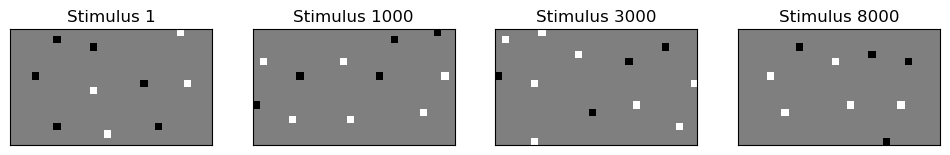

In [8]:
stim_indices = [1, 1000, 3000, 8000]
fig, axes = plt.subplots(1, len(stim_indices), figsize=(len(stim_indices) * 3, 3))
for i, i_stim in enumerate(stim_indices):
    ax = axes[i]
    ax.set_title(f"Stimulus {i_stim}")
    ax.imshow(stim[i_stim], cmap='gray')
    ax.set_xticks([]); ax.set_yticks([]);
print("Minimal value of a pixel: ", np.min(stim[i_stim]))
print("Maximal value of a pixel: ", np.max(stim[i_stim]))
print('Shape of Stimulus:', stim[i_stim].shape)

Let's convert the values of the pixels to the normalized range from $-1$ to $+1$. This way if pixel is not activated, in the original data it will take value equals $127$, which will be transformed into $0$. If it was black, it will take value $0$, which is converted to $-1$, and $255$ will be converted to $+1$.

In [9]:
stim = stim.astype(int)
stim[stim == 0]   = -1
stim[stim == 127] = 0
stim[stim == 255] = 1
np.unique(stim)

array([-1,  0,  1])

#### Distribution of a single pixel

Probability of different stimulus values across image presentations: 
-1: 0.0131
0: 0.9749
1: 0.0120


Text(0.5, 1.0, 'Counts of pixel at location (5,5) for all stimulus')

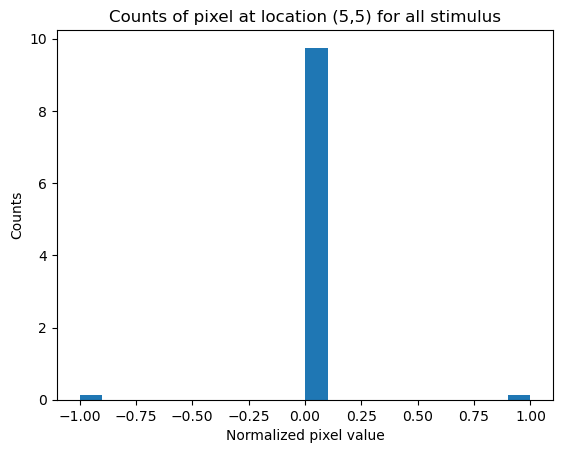

In [10]:
p0, p1 = (5, 5) # pixel coordinates
pixel_vals = stim[:, p0, p1]
print("Probability of different stimulus values across image presentations: ")
for val in [-1, 0, 1]:
    print(f"{val}: {np.sum(pixel_vals == val) / pixel_vals.size:.4f}")
plt.hist(pixel_vals, bins=20, density=True);
plt.xlabel('Normalized pixel value')
plt.ylabel('Counts')
plt.title('Counts of pixel at location (5,5) for all stimulus')

From above graph, we can conclude that the stimulus presented is sparse noise as most of the pixel values are zeros.

## Calcium imaging

### Locations

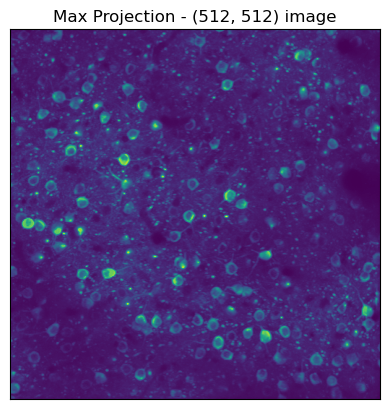

In [11]:
plt.imshow(data['max_projection'])
plt.title(f"Max Projection - {data['max_projection'].shape} image");
plt.xticks([]); plt.yticks([]);


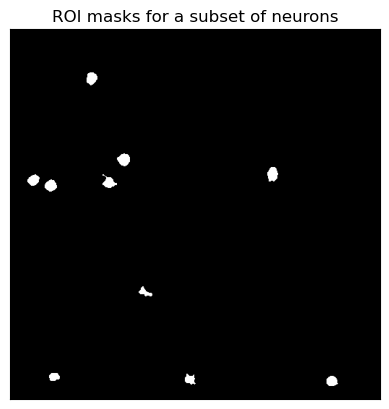

In [12]:
roi_layers = np.zeros(roi_shape)
for neuron in range(0, 100, 10):
    roi_layers += roi[neuron]
plt.imshow(roi_layers, cmap='gray')
plt.title("ROI masks for a subset of neurons")
plt.xticks([]); plt.yticks([]);

Let's look at the location mask in more detail.
For this let's find values of $x$ and $y$, which are defining the borders of ROI - this will allow to zoom in the ROI mask automatically.

In [13]:
list(range(0, 100, 10))

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

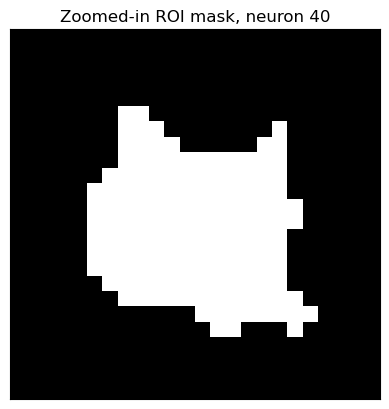

In [14]:
neuron = 40
roi_example = roi[neuron]
x_nonzero = np.nonzero(roi_example.sum(axis=0))[0]
y_nonzero = np.nonzero(roi_example.sum(axis=1))[0]
xmin, xmax = x_nonzero[0] - 5, x_nonzero[-1] + 5
ymin, ymax = y_nonzero[0] - 5, y_nonzero[-1] + 5

plt.title(f"Zoomed-in ROI mask, neuron {neuron}")
plt.imshow(roi_example[ymin:ymax, xmin:xmax], cmap='gray')
plt.xticks([]); plt.yticks([]);

## Pre-processing

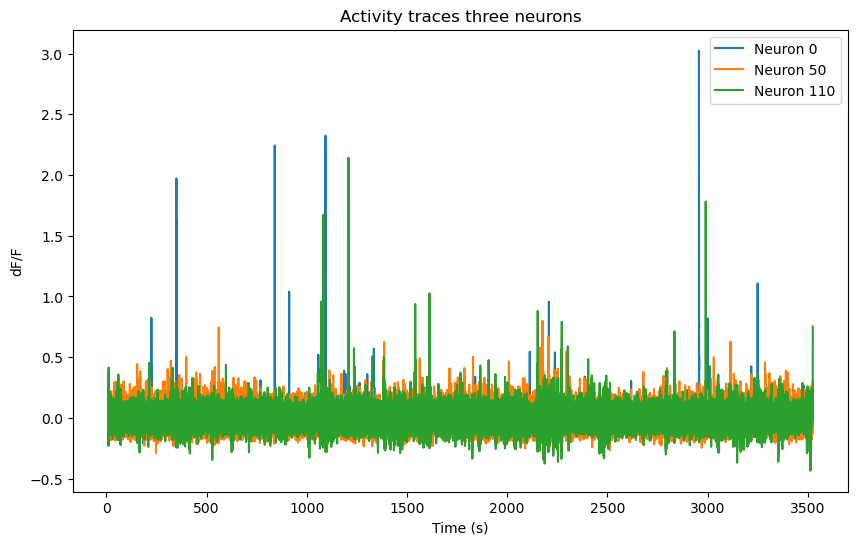

In [15]:
# Plot the activity traces of 3 randomly selected neurons
neurons_to_plot = [0,50,110]
fig, ax = plt.subplots(figsize=(10, 6)) 
for i in neurons_to_plot: 
    ax.plot(times, dff[i], label=f"Neuron {i}") 
    ax.set_xlabel("Time (s)") 
    ax.set_ylabel("dF/F") 
    ax.set_title("Activity traces three neurons") 
    ax.legend() 
plt.show()

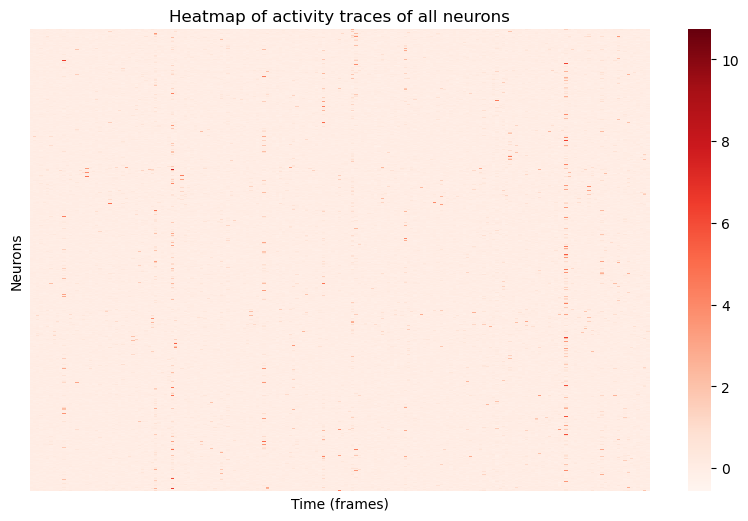

In [16]:
# Plot heatmap of activity traces of all neurons
plt.figure(figsize=(10,6))
sns.heatmap(dff.T, xticklabels=False, yticklabels=False, cmap='Reds', cbar=True)
plt.xlabel('Time (frames)')
plt.ylabel('Neurons')
plt.title('Heatmap of activity traces of all neurons')
plt.show()

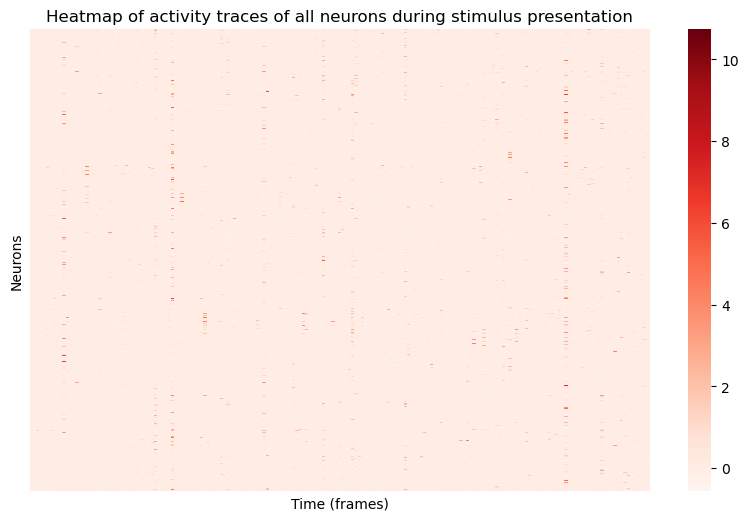

In [17]:
# Plot heatmap of activity traces of all neurons during stimulus presentation
stim_start = stim_table['start'].values # start frames of stimuli
stim_end = stim_table['end'].values # end frames of stimuli
stim_dff = dff[:, stim_start[0]:stim_end[-1]] # extract dff during stimuli
stim_times = times[stim_start[0]:stim_end[-1]] # extract times during stimuli

plt.figure(figsize=(10,6))
sns.heatmap(stim_dff.T, xticklabels=False, yticklabels=False, cmap='Reds', cbar=True)
plt.xlabel('Time (frames)')
plt.ylabel('Neurons')
plt.title('Heatmap of activity traces of all neurons during stimulus presentation')
plt.show()


### Extracting spikes from calcium traces

In [18]:
import oopsi
from tqdm import tqdm

dt = dt=times[1]-times[0]
samp_freq=1/dt

calcium_spikes=np.empty(dff.shape)

for i in tqdm(range(n_neurons)):
    d_gcamp, C_gcamp = oopsi.fast(dff[i,:], dt=dt, iter_max=5, update=True)
    calcium_spikes[i,:] = d_gcamp

100%|██████████| 189/189 [1:03:06<00:00, 20.03s/it]


In [24]:
# calcium_spikes_frame =  pd.DataFrame(calcium_spikes)
# calcium_spikes_frame.to_csv('Calcium_spikes.csv', index=False)

# calcium_spikes_frame = pd.read_csv('Calcium_spikes.csv', index=False)
# calcium_spikes = calcium_spikes_frame.iloc[:,:].values

Text(0.5, 0.98, 'Neuron: 6')

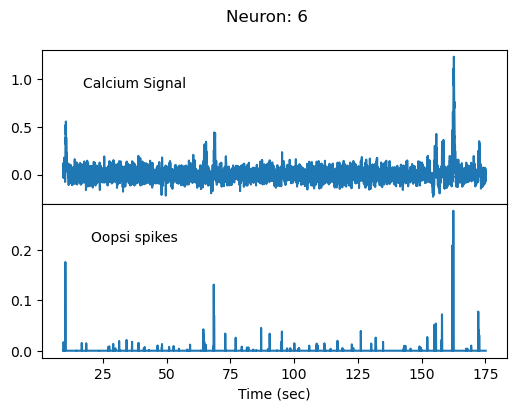

In [19]:
# Ploting the results for the GCamp Cell 
start_ind = 0
end_ind = 5000
neuron = 6

fig, axs = plt.subplots(
    2, 1, figsize=(6, 4), height_ratios=[1, 1], gridspec_kw=dict(hspace=0)
)

datas = [dff[neuron,:], calcium_spikes[neuron,:]]
titles = ["Calcium Signal", "Oopsi spikes"]

for i, (data, title) in enumerate(zip(datas, titles)):
    axs[i].plot(times[start_ind:end_ind], data[start_ind:end_ind])
    axs[i].set_title(title, x=0.2, y=0.7, fontsize=10)

axs[1].set_xlabel("Time (sec)")
fig.suptitle(f'Neuron: {neuron}')

##### Plotting Raster plot: along time axis

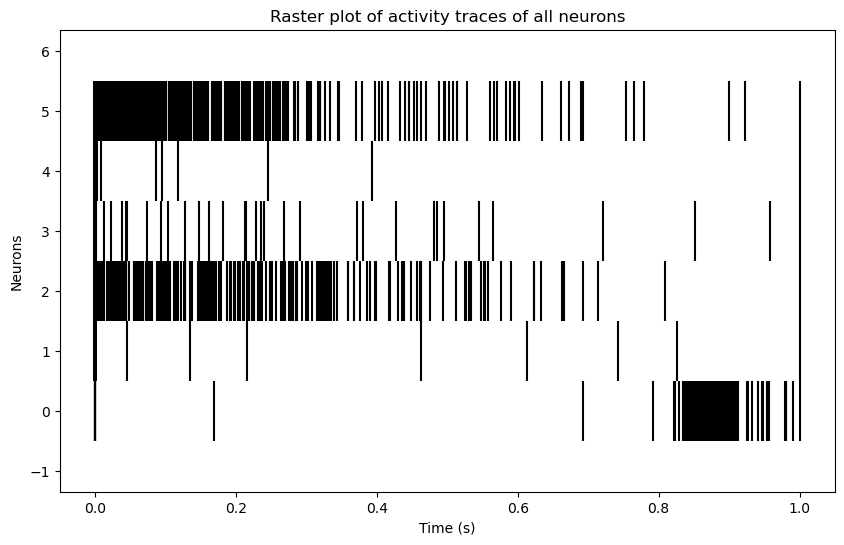

In [20]:
plt.figure(figsize=(10,6))
plt.eventplot(calcium_spikes[0:6,:], colors='k') # plot the spike times as horizontal lines
plt.xlabel('Time (s)')
plt.ylabel('Neurons')
plt.title('Raster plot of activity traces of all neurons')
plt.show()


##### Plotting Raster plot: relative to stimulus onset

In [21]:
# Define a function to create a raster plot from a list of lists
def raster_plot(spike_times,neuron):
    plt.figure(figsize=(10,6))
    n_trials = len(spike_times) # get the number of trials
    for i in range(n_trials): # loop over all trials
        trial_spikes = spike_times[i] # get the spike times for this trial
        plt.vlines(trial_spikes, i + 0.5, i + 1.5, color='k') # plot the spike times as vertical lines
    plt.xlabel('Time relative to stimulus onset')
    plt.ylabel('Trials')
    plt.title(f'Raster plot of activity traces of neurons: {neuron}')
    plt.show()

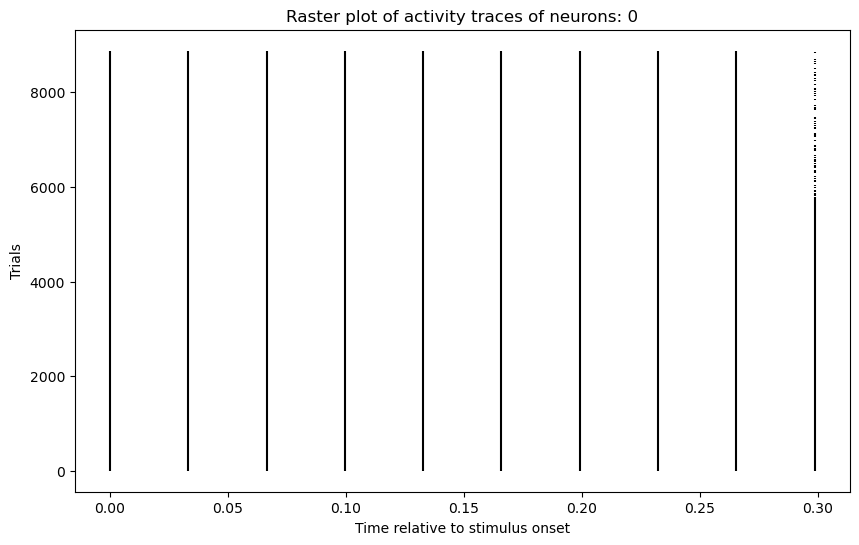

In [22]:
# Plot raster plot of activity traces of all neurons with respect to stimulus onset
# times = times * 1000 # convert times from seconds to milliseconds
stim_onset = times[stim_table['start'].values] 
stim_offset = times[stim_table['end'].values]
stim_duration = stim_offset - stim_onset

max_duration = np.max(stim_duration) # find the maximum duration of stimuli
n_trials = len(stim_onset) # get the number of trials
neuron=0

spike_times = [] 
for i in range(n_trials): # loop over all trials
    trial_start = stim_onset[i]  # get the start time of the trial window
    trial_end = stim_onset[i] + max_duration # get the end time of the trial window
    trial_spike = calcium_spikes[neuron, (times >= trial_start) & (times < trial_end)] # extract the dff values within the trial window

    threshold = 0 # set a threshold for spike detection => spikes if there is any activity above 0
    trial_spikes = np.where(trial_spike > threshold) # find the indices where dF/F exceeds the threshold
    times1 = times[(times >= trial_start) & (times < trial_end)]
    trial_spike_times = np.take(times1, trial_spikes) - stim_onset[i] # get the spike times relative to the stimulus onset using np.take function
    spike_times.append(trial_spike_times)

raster_plot(spike_times,neuron)